In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pyrcel as pm
import matplotlib.pyplot as plt
import aerosol_plots as aerplt
import calculations as clc
import parcel_anim as panim

In [194]:
def get_real_aerosols():
    # aerosol type (citation)
    # prop = [name, mean radius (um), hygroscopicity=kappa]

    # ammonium sulfate aerosol (Chen et al., 2018)
    sulf = ['sulfate', 0.06, 0.61]
    # sea salt aerosol (Zieger et al., 2017)
    seasalt = ['sea-salt', 0.2, 1.1]
    # mineral dust (Johnson & Osborne, 2011), (Koehler et al., 2009)
    mindust = ['mineral-dust', 1.3, 0.045]
    # black carbon (Wu et al., 2017), (Liu et al., 2013)
    blkcarb = ['black-carbon', 0.213, 0.09]
    # fresh biomass burning (Yi, 2018)
    freshburn = ['fresh-biomass-burning', 0.074, 0.21]
    # urban (Kreidenweis & Asa-Awuku, 2014).
    urban = ['urban', 0.2, 0.2]
    # aged biomass burning (Malm et al., 2005), (Kreidenweis & Asa-Awuku, 2014) [(Yi, 2018) = 0.29]
    ageburn = ['aged-biomass-burning', 0.33, 0.04]

    aerosol_list = list([sulf, seasalt, mindust, blkcarb,
                        urban, freshburn, ageburn])
    
    return(aerosol_list)

def generate_aerosols():
    # aerosol type (citation)
    # prop = [name, mean radius (um), hygroscopicity=kappa]

    mu = 0.1
    aerosol_list = list()
    for kappa in np.linspace(0,1.5,9):
        aer = ['', mu, kappa]
        aerosol_list.append(aer)

    # ammonium sulfate aerosol (Chen et al., 2018)
    sulf = ['sulfate', mu, 0.61]
    # sea salt aerosol (Zieger et al., 2017)
    seasalt = ['sea-salt', mu, 1.1]
    # mineral dust (Johnson & Osborne, 2011), (Koehler et al., 2009)
    mindust = ['mineral-dust', mu, 0.045]
    # black carbon (Wu et al., 2017), (Liu et al., 2013)
    blkcarb = ['black-carbon', mu, 0.09]
    # fresh biomass burning (Yi, 2018)
    freshburn = ['fresh-biomass-burning', mu, 0.21]
    # aged biomass burning (Malm et al., 2005), (Kreidenweis & Asa-Awuku, 2014) [(Yi, 2018) = 0.29]
    ageburn = ['aged-biomass-burning', mu, 0.04]

    aerosol_list = list([sulf, seasalt, mindust, blkcarb, freshburn, ageburn])

    return(aerosol_list)

In [71]:
def runparcel(aerosols, h):
    npop = len(aerosols)

    # environmental variables
    P0 = 1e5  # Initial Pressure, Pa
    T0 = 280.   # Initial Temperature, K
    S0 = -0.15  # Initial Supersaturation, 1-RH (85% here)

    # regime-determining variables
    w = 6.0  # updraft velocity (m/s)
    Ntot = w*2.0e3 # total particle number
    N = Ntot/npop # particle number per population

    # initial lognormal distribution variables
    # shared variables
    sig = 1.5  # geometric standard deviation
    bins = 200 # number of bins to track (maybe choose this in relation to sigma)

    initial_aerosols = list()
    for i in np.arange(npop):
        prop = aerosols[i]
        [name,mu,kappa] = prop
        aer = pm.AerosolSpecies(name, pm.Lognorm(
            mu=mu, sigma=sig, N=N), kappa=kappa, bins=bins)
        initial_aerosols.append(aer)

    dt = 1.0  # timestep (s)
    h_end = h  # end altitude (m)
    t_end = h_end/w  # end time (s)

    model = pm.ParcelModel(initial_aerosols, w, T0, S0,
                           P0, console=False, accom=0.5)
    parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

    return(initial_aerosols, parcel_trace, aerosol_traces)

In [167]:
# create aerosol list to test on 
#aerosol_list = get_real_aerosols()
aerosol_list = generate_aerosols()
names = np.array(aerosol_list)[:,0]
names, aerosol_list = zip(*sorted(zip(names, aerosol_list), key=lambda t: t[0]))

cols = ['orange','black','red','purple','blue','limegreen','pink','teal','gold']
cols = dict(zip(names, cols[0:len(names)]))

In [168]:
# max height for simulation
h = 1e3

# create list of all aerosol tests
init_aerosols_list = list()
parcel_trace_list = list()
aerosol_trace_list = list()

# run parcel for individual aerosol species
for aerosol in aerosol_list:
    initial_aerosols, parcel_trace, aerosol_trace = runparcel([aerosol], h)
    init_aerosols_list.append(initial_aerosols)
    parcel_trace_list.append(parcel_trace)
    aerosol_trace_list.append(aerosol_trace)

# run experiment on pairs aerosol species
# test all combinations
for i in np.arange(len(aerosol_list)):
    for j in np.arange(len(aerosol_list)):
        if j > i:
            initial_aerosols, parcel_trace, aerosol_trace = runparcel([aerosol_list[i], aerosol_list[j]], h)
            init_aerosols_list.append(initial_aerosols)
            parcel_trace_list.append(parcel_trace)
            aerosol_trace_list.append(aerosol_trace)

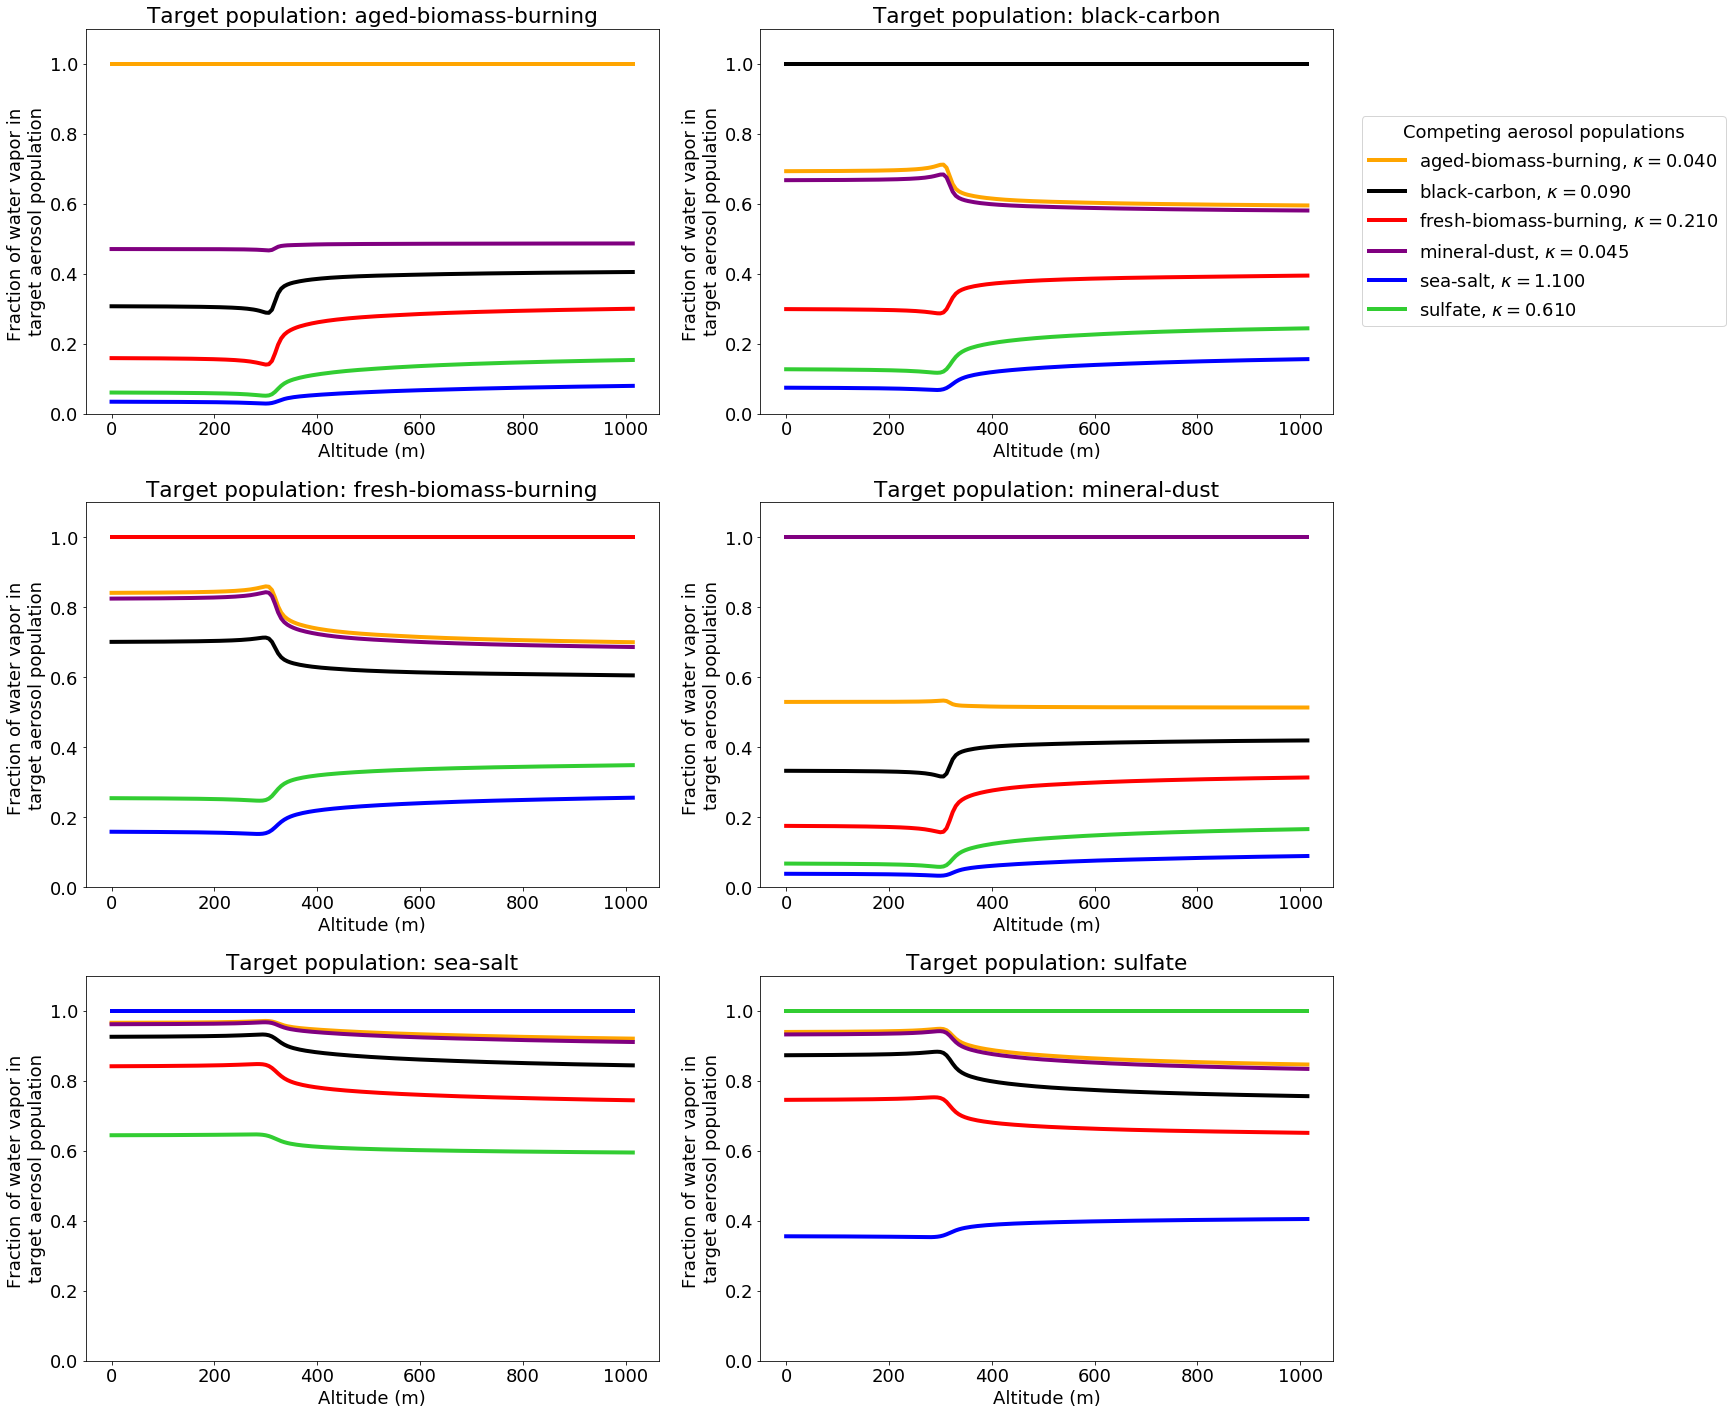

In [169]:
# create figure for plotting
fig = plt.figure(figsize=(25,20))

# loop over aerosol species
for s,species in enumerate(names): 
#     # create figure for plotting
#     fig = plt.figure(figsize=(10,6))
    
    # add subplot
    plt.subplot(3,2,s+1)

    # loop over parcels
    for i,atrace in enumerate(aerosol_trace_list):
        ptrace = parcel_trace_list[i]
        init = init_aerosols_list[i]

        #initialize lists
        water_vols = list()
        rates = list()

        # loop over aerosol pops in parcel
        for j,name in enumerate(atrace):
            N = init[j].Nis
            rd = init[j].r_drys
            r = atrace[name].values

            # compute total volume of population
            vol = clc.calc_tot_vol(r,N)
            vdry = clc.calc_tot_vol(rd,N)
            growth_rate = np.diff(vol)/vol[0:-1]*100
            water_vol = vol - vdry

            # add to list
            rates.append(growth_rate)
            water_vols.append(water_vol)

        # compute fraction of water vapor in each population
        water_vols = np.array(water_vols)
        tot_water = sum(water_vols)
        frac_water = water_vols/tot_water

        # loop over aerosol pops in parcel
        keys = list(atrace.keys())
        for j,name in enumerate(atrace):
            # check if target species for plot
            if name == species:
                if len(keys) == 1:
                    othername = species
                else:
                    othername = keys[j-1]
                label = othername+", $\kappa={:.3f}$".format(init[j-1].kappa)
                alt = ptrace["z"]
                plt.plot(alt,frac_water[j,:],'-', lw=4, color=cols[othername], label=label)

    # set plot parameters
    plt.title("Target population: "+species)
    plt.ylim([0,1.1])
    plt.xlabel("Altitude (m)")
    plt.ylabel("Fraction of water vapor in \ntarget aerosol population")
    
    if s+1 == 2:
        # sort legend alphabetically
        ax=plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(handles, labels, title="Competing aerosol populations", loc='center right', bbox_to_anchor=(1.7,0.5))
    
#     # sort legend alphabetically
#     ax=plt.gca()
#     handles, labels = ax.get_legend_handles_labels()
#     labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#     ax.legend(handles, labels, title="Competing aerosol populations", loc='top right', bbox_to_anchor=(1.0, 1.02))
        
#     plt.rcParams.update({'font.size': 12})
#     plt.tight_layout()
#     plt.savefig("./figs/competition/water_frac_"+species+".png",dpi=300)
#     plt.show()
#     plt.close()

plt.rcParams.update({'font.size': 18})
plt.tight_layout()
plt.savefig("./figs/competition/water_frac_panel.png",dpi=300)
plt.show()
plt.close()

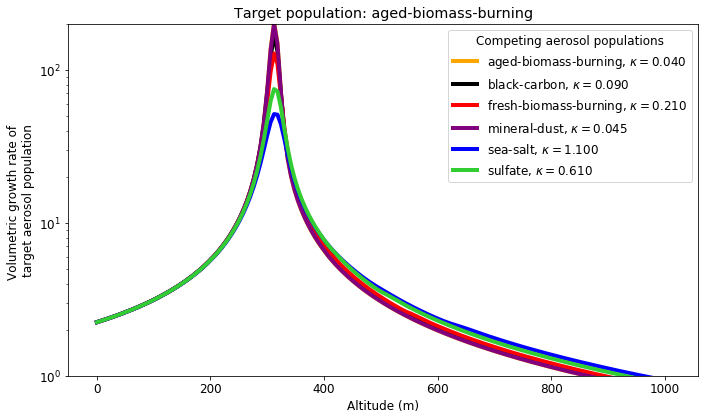

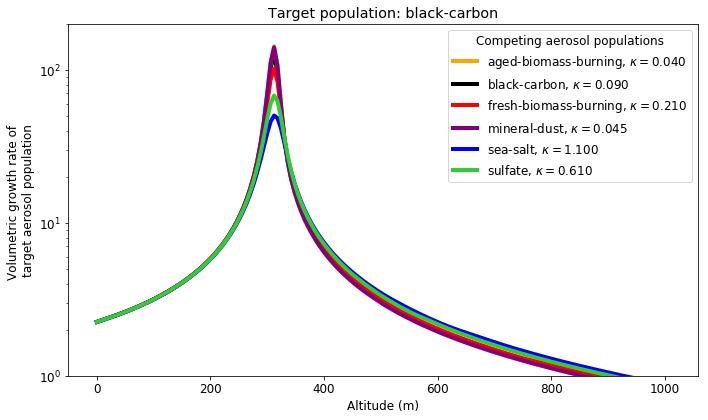

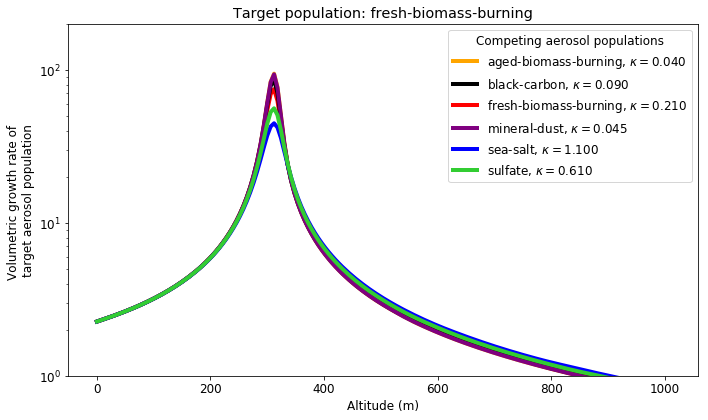

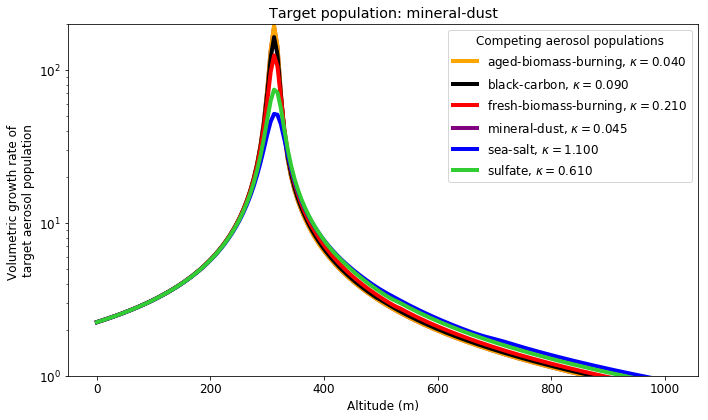

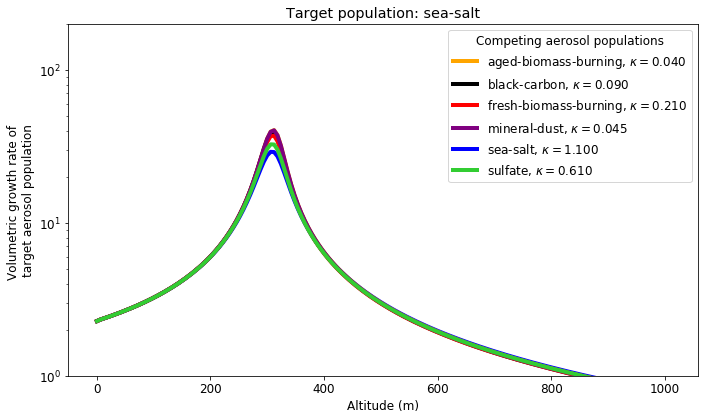

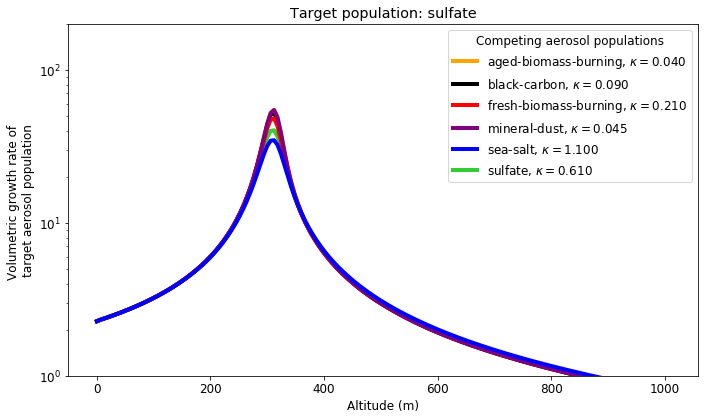

In [195]:
# # create figure for plotting
# fig = plt.figure(figsize=(25,20))

# loop over aerosol species
for s,species in enumerate(names): 
    # create figure for plotting
    fig = plt.figure(figsize=(10,6))
    
#     # add subplot
#     plt.subplot(3,2,s+1)

    # loop over parcels
    for i,atrace in enumerate(aerosol_trace_list):
        ptrace = parcel_trace_list[i]
        init = init_aerosols_list[i]

        #initialize lists
        water_vols = list()
        rates = list()

        # loop over aerosol pops in parcel
        for j,name in enumerate(atrace):
            N = init[j].Nis
            rd = init[j].r_drys
            r = atrace[name].values

            # compute total volume of population
            vol = clc.calc_tot_vol(r,N)
            vdry = clc.calc_tot_vol(rd,N)
            growth_rate = np.diff(vol)/vol[0:-1]*100
            water_vol = vol - vdry
            growth_rate = np.diff(water_vol)/water_vol[0:-1]*100

            # add to list
            rates.append(growth_rate)
            water_vols.append(water_vol)

        # compute fraction of water vapor in each population
        water_vols = np.array(water_vols)
        tot_water = sum(water_vols)
        frac_water = water_vols/tot_water

        # loop over aerosol pops in parcel
        keys = list(atrace.keys())
        for j,name in enumerate(atrace):
            # check if target species for plot
            if name == species:
                if len(keys) == 1:
                    othername = species
                else:
                    othername = keys[j-1]
                label = othername+", $\kappa={:.3f}$".format(init[j-1].kappa)
                alt = ptrace["z"].iloc[0:-1]
                plt.plot(alt,rates[j],'-', lw=4, color=cols[othername], label=label)

    # set plot parameters
    plt.title("Target population: "+species)
    plt.ylim([1,200])
    plt.yscale("log")
    plt.xlabel("Altitude (m)")
    plt.ylabel("Volumetric growth rate of \ntarget aerosol population")
    
#     if s+1 == 2:
#         # sort legend alphabetically
#         ax=plt.gca()
#         handles, labels = ax.get_legend_handles_labels()
#         labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
#         ax.legend(handles, labels, title="Competing aerosol populations", loc='center right', bbox_to_anchor=(1.7,0.5))
    
    # sort legend alphabetically
    ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, title="Competing aerosol populations", loc='top right')
        
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    plt.savefig("./figs/competition/growth_rate_"+species+".png",dpi=300)
    plt.show()
    plt.close()

# plt.rcParams.update({'font.size': 18})
# plt.tight_layout()
# plt.savefig("./figs/competition/growth_rate_panel.png",dpi=300)
# plt.show()
# plt.close()